Clasificación de imágenes utilizando el dataset "fashion_mnist"

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
#Cargamos los datos a utilizar
datos, metadatos = tfds.load("fashion_mnist", as_supervised = True, with_info = True)

In [3]:
metadatos

tfds.core.DatasetInfo(
    name='fashion_mnist',
    full_name='fashion_mnist/3.0.1',
    description="""
    Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.
    """,
    homepage='https://github.com/zalandoresearch/fashion-mnist',
    data_path='/root/tensorflow_datasets/fashion_mnist/3.0.1',
    file_format=tfrecord,
    download_size=29.45 MiB,
    dataset_size=36.42 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{DBLP:journals/corr/abs-1708-07747,
      author    

In [4]:
#Separamos los datos de entrenamiento y los de prueba que incluye el propio dataset en dos variables
datos_entrenamiento, datos_pruebas = datos["train"], datos["test"]

In [5]:
#Vemos los nombres de las categorías que existen en el set, que almacenamos previamente en "metadatos"
nombres_clases = metadatos.features["label"].names
nombres_clases

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [6]:
# Normalizer los datos (pasar de 0-255 a 0-1)

def normalizar(imagenes, etiquetas):
  imagenes = tf.cast(imagenes, tf.float32)
  imagenes /= 255  #Aquí cambiamos de la escala 0-255 a 0-1
  return imagenes, etiquetas

# Normalizamos los datos de entrenamiento y prueba con la función que hicimos
datos_entrenamiento = datos_entrenamiento.map(normalizar)
datos_pruebas = datos_pruebas.map(normalizar)

# Agregar a cache (usar memoria en lugar de disco para almacenar datos, entrenamiento más rápido)
datos_entrenamiento = datos_entrenamiento.cache()
datos_pruebas = datos_pruebas.cache()

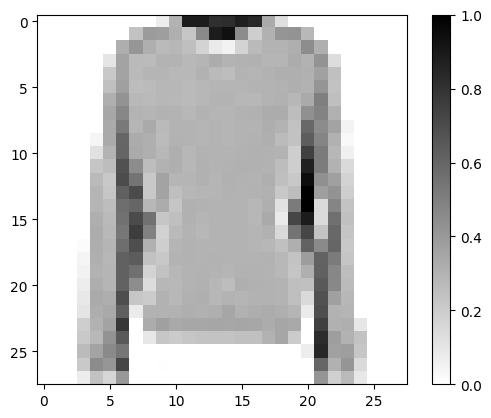

In [7]:
# Mostrar una imagen de los datos de prueba (la primera en este caso)
for imagen, etiqueta in datos_entrenamiento.take(1):
  break
imagen = imagen.numpy().reshape((28,28)) #Redimensionamos

import matplotlib.pyplot as plt

#Plotear
plt.figure()
plt.imshow(imagen, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

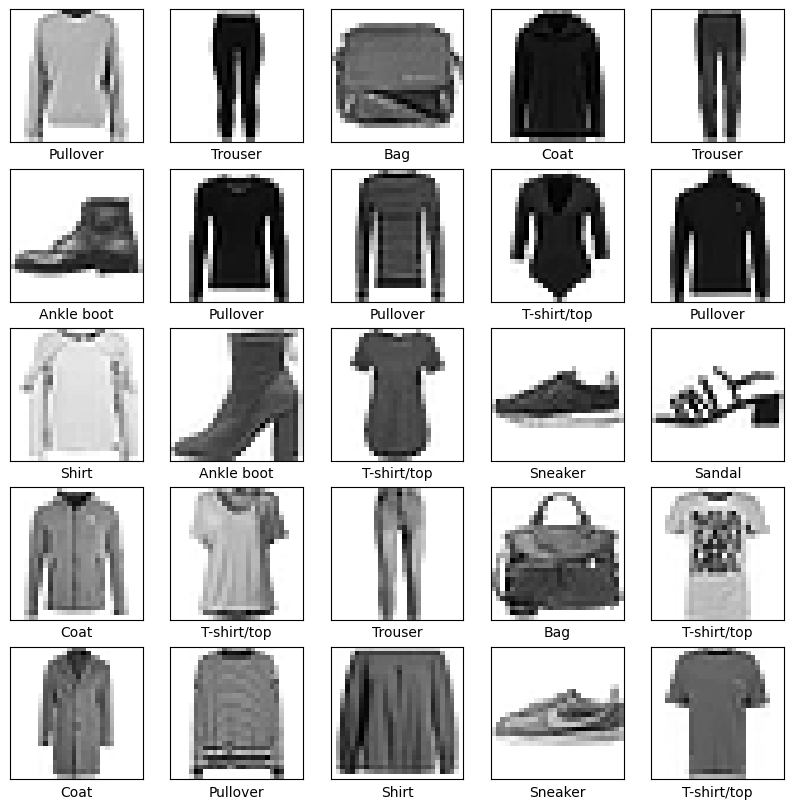

In [8]:
plt.figure(figsize=((10,10)))
for i, (imagen, etiqueta) in enumerate(datos_entrenamiento.take(25)):
  imagen = imagen.numpy().reshape((28,28))
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(imagen, cmap=plt.cm.binary)
  plt.xlabel(nombres_clases[etiqueta])
plt.show()

In [9]:
#Crear el modelo

modelo = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28,28,1)), #Cada imagen presenta 28x28 pixeles y un acanl (blanco y negro). La capa Flatten convierte esto a una sola dimensión
    tf.keras.layers.Dense(50, activation=tf.nn.relu), #Capa oculta 1 (función de activación relu - mantiene los valores positivos iguales y los negativos los convierte en cero)
    tf.keras.layers.Dense(50, activation=tf.nn.relu), #Capa oculta 2 (función de activación relu)
    tf.keras.layers.Dense(10, activation=tf.nn.softmax) #Capa de salida (función de activación softmax - para redes clasificatorias, para asegurar que las sumas de las neuronas de salida siempre de 1)
])

In [10]:
#Compilar el modelo

modelo.compile(
    optimizer = "adam",
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics = ["accuracy"]
)

In [11]:
#Almacenamos en variables la cantidad de datos de entrenamiento y de prueba, para emplearla a continuación

num_ej_entrenamiento = metadatos.splits["train"].num_examples
num_ej_pruebas = metadatos.splits["test"].num_examples

print(num_ej_entrenamiento)
print(num_ej_pruebas)


60000
10000


In [12]:
#Dada la gran cantidad de datos podemos decirle a la red que entrene en lotes

tamano_lote = 32

datos_entrenamiento = datos_entrenamiento.repeat().shuffle(num_ej_entrenamiento).batch(tamano_lote) #Usamos batch() para que vaya entrenando por lotes según la variable tamano_lote
datos_pruebas = datos_pruebas.batch(tamano_lote)

In [13]:
#Entrenamiento
import math

historial = modelo.fit(datos_entrenamiento, epochs=5, steps_per_epoch=math.ceil(num_ej_entrenamiento/tamano_lote))

Epoch 1/5
1875/1875 [==============================] - 19s 4ms/step - loss: 0.5152 - accuracy: 0.8197
Epoch 2/5
1875/1875 [==============================] - 5s 2ms/step - loss: 0.3830 - accuracy: 0.8612
Epoch 3/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3504 - accuracy: 0.8715
Epoch 4/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3245 - accuracy: 0.8822
Epoch 5/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3107 - accuracy: 0.8855


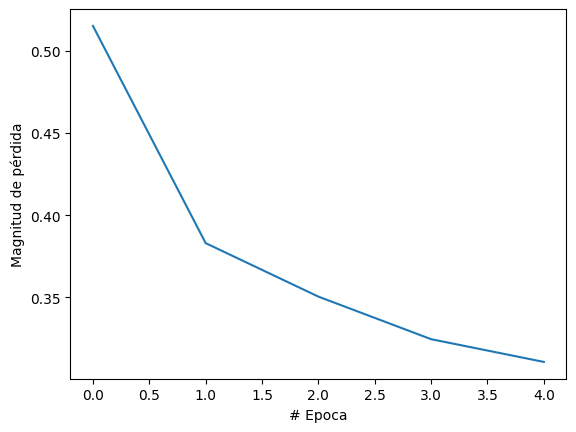

In [14]:
plt.xlabel("# Epoca")
plt.ylabel("Magnitud de pérdida")
plt.plot(historial.history["loss"])

1/1 [==============================] - 0s 69ms/step


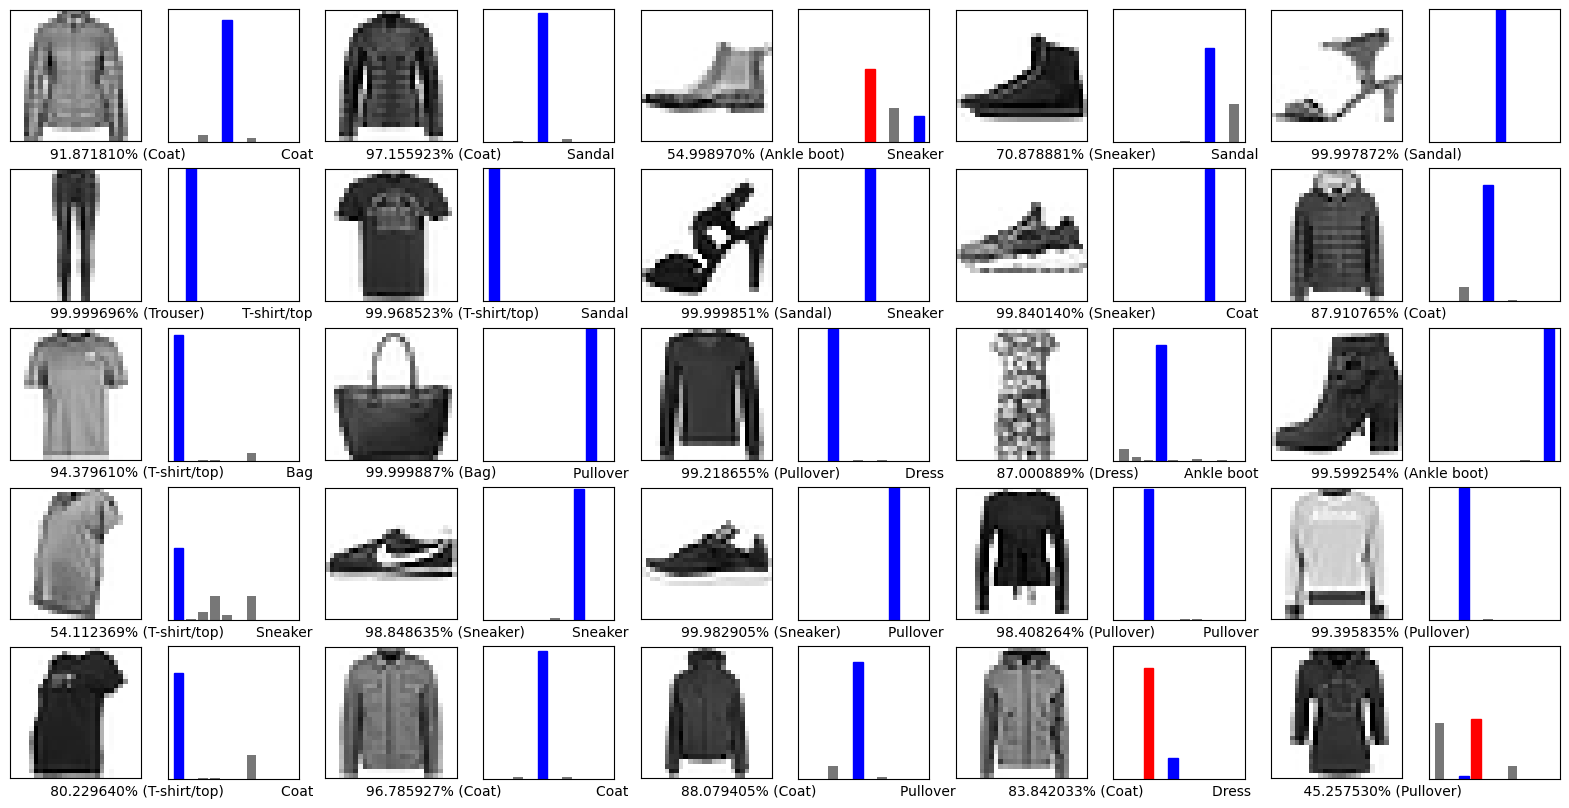

In [15]:
#Prueba

#Imprimiré 25 imágenes del set de prueba y trataré de que clasifique cada una

import numpy as np

for imagenes_prueba, etiquetas_prueba in datos_pruebas.take(1):
  imagenes_prueba=imagenes_prueba.numpy()
  etiquetas_prueba=etiquetas_prueba.numpy()
  predicciones = modelo.predict(imagenes_prueba)

def graficar_imagen(i, arr_predicciones, etiquetas_reales, imagenes):
  arr_predicciones, etiqueta_real, img = arr_predicciones[i], etiquetas_reales[i], imagenes[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img[...,0], cmap=plt.cm.binary)

  etiqueta_prediccion= np.argmax(arr_predicciones)
  if etiqueta_prediccion == etiqueta_real:
    color ="blue" #Colorea de azul si la predicción acierta
  else:
    color="red" #Colorea de rojo si la predicción falla

  plt.xlabel("{} {:20f}% ({})".format(
      nombres_clases[etiqueta_prediccion],
      100*np.max(arr_predicciones),
      nombres_clases[etiqueta_real],
      color=color
  ))

def graficar_valor_arreglo(i, arr_predicciones, etiqueta_real):
  arr_predicciones, etiqueta_real = arr_predicciones[i], etiqueta_real[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  grafica = plt.bar(range(10), arr_predicciones, color="#777777")
  plt.ylim([0,1])
  etiqueta_prediccion = np.argmax(arr_predicciones)

  grafica[etiqueta_prediccion].set_color("red")
  grafica[etiqueta_real].set_color("blue")

filas=5
columnas=5
num_imagenes=filas*columnas
plt.figure(figsize=(2*2*columnas, 2*filas))
for i in range(num_imagenes):
  plt.subplot(filas, 2*columnas, 2*i+1)
  graficar_imagen(i, predicciones, etiquetas_prueba, imagenes_prueba)
  plt.subplot(filas, 2*columnas, 2*i+2)
  graficar_valor_arreglo(i, predicciones, etiquetas_prueba)

In [16]:
#Tomar cualquier índice del set de pruebas para ver su predicción

imagen=imagenes_prueba[10]
imagen=np.array([imagen])
prediccion=modelo.predict(imagen)

print("Predicción:" + nombres_clases[np.argmax(prediccion[0])])

1/1 [==============================] - 0s 77ms/step
Predicción:T-shirt/top


In [17]:
#Exportación del modelo
modelo.save("modelo_exportado.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [18]:
#Instalar tensorflowjs
!pip install tensorflowjs

In [19]:
#Convertir el archivo h5 a formato de tensorflowjs para usarse en una web
!mkdir tfjs targe_dir
!tensorflowjs_converter --input_format keras modelo_exportado.h5 tfjs_target_dir

mkdir: cannot create directory ‘tfjs’: File exists
mkdir: cannot create directory ‘targe_dir’: File exists
2023-10-02 19:25:31.234346: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-02 19:25:31.234422: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-02 19:25:31.234469: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-02 19:25:32.502187: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [20]:
# Comprobar si creo la carpeta
!ls

modelo_exportado.h5  sample_data  targe_dir  tfjs  tfjs_target_dir


In [21]:
#Comprobamos el contenido de la carpeta
!ls tfjs_target_dir

group1-shard1of1.bin  model.json
